# Sentiment Analysis Rotten Tomato - TensorFlow

In [1]:
!nvidia-smi

Mon Nov  9 04:29:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu >> /dev/null

In [3]:
!pip install --upgrade grpcio >> /dev/null

In [4]:
!pip install tqdm  >> /dev/null

In [5]:
!pip install bert-for-tf2 >> /dev/null

In [6]:
!pip install sentencepiece >> /dev/null

In [7]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

## Data

In [9]:
df_train=pd.read_csv('drive/My Drive/rotten2/train.tsv',delimiter='\t')

In [10]:
df_train.shape

(156060, 4)

In [11]:
df_train.head(3)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2


In [12]:
def relabel(label):
    label = int(label)
    if label < 2:
        return 0
    elif label == 2:
        return 1
    else:
        return 2

df_train['Sentiment'] = df_train['Sentiment'].apply(relabel)
df_train['Sentiment'].unique()

array([0, 1, 2])

In [13]:
df_train.Sentiment.value_counts()

1    79582
2    42133
0    34345
Name: Sentiment, dtype: int64

In [14]:
label0_count = 34345

df_0label = df_train.loc[df_train['Sentiment']==0]
df_1label = df_train.loc[df_train['Sentiment']==1]
df_2label = df_train.loc[df_train['Sentiment']==2]

print(df_0label.shape)
print(df_1label.shape)
print(df_2label.shape)

(34345, 4)
(79582, 4)
(42133, 4)


In [15]:
balanced_1label = df_1label.sample(label0_count)
balanced_2label = df_2label.sample(label0_count)
print(df_0label.shape, balanced_1label.shape, balanced_2label.shape)

(34345, 4) (34345, 4) (34345, 4)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


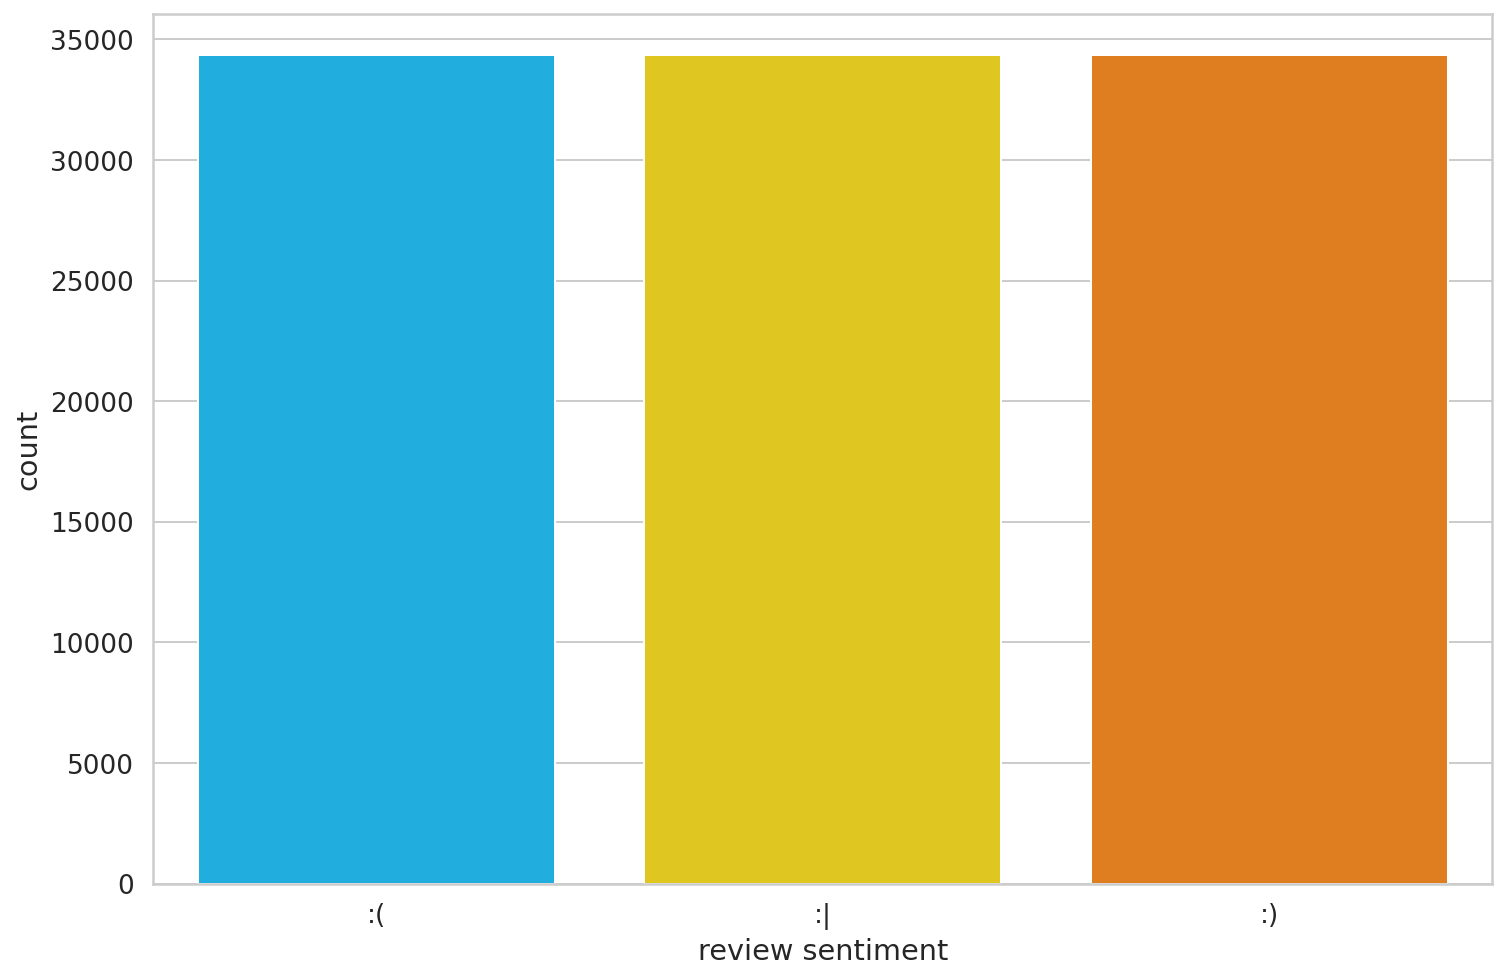

In [16]:
df_train = pd.concat([df_0label, balanced_1label, balanced_2label])
ax = sns.countplot(df_train['Sentiment'])
plt.xlabel('review sentiment')
ax.set_xticklabels([':(', ":|", ":)"]);

In [17]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_train.shape

(103035, 4)

In [18]:
df_train, df_test = train_test_split(df_train, test_size=0.2)
df_train.shape, df_test.shape

((82428, 4), (20607, 4))

# Bert

In [19]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-11-09 04:30:10--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   169MB/s    in 2.3s    

2020-11-09 04:30:13 (169 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [20]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [21]:
os.makedirs("model", exist_ok=True)

In [22]:
!mv uncased_L-12_H-768_A-12/ model

In [23]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [24]:
tokenizer = FullTokenizer(
  vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt")
)

In [25]:
tokens = tokenizer.tokenize("and he scrapped away my dignity in the name of love")
print(tokens)
tokenizer.convert_tokens_to_ids(tokens)

['and', 'he', 'scrapped', 'away', 'my', 'dignity', 'in', 'the', 'name', 'of', 'love']


[1998, 2002, 14553, 2185, 2026, 13372, 1999, 1996, 2171, 1997, 2293]

In [26]:
class MovieReviewData:
  DATA_COLUMN = "Phrase"
  LABEL_COLUMN = "Sentiment"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=100):

    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max sequence length", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
  
  def _prepare(self, df):
    
    x, y = [], []

    for _, row in tqdm(df.iterrows()):

      text, label = row[MovieReviewData.DATA_COLUMN], row[MovieReviewData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))
    
    return np.array(x), np.array(y)
  
  def _pad(self, ids):
    # truncate and pad
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

## Fine Tune

In [27]:
def create_model(max_seq_len, bert_ckpt_file, bert_config_file, classes):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
    bc = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    bert = BertModelLayer.from_params(bert_params, name="bert")
    
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  # final layer
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  # ! Dropout = 0.4, lets flatten, 768 hidden layers
  cls_out = keras.layers.Dropout(0.4)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.4)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)

  return model

In [28]:
classes = df_train.Sentiment.unique().tolist()
classes

[1, 0, 2]

In [29]:
# the dataset Train AND Test
# pre processed --> truncated and padded to maximum length seq
data = MovieReviewData(df_train, df_test, tokenizer, classes, max_seq_len=100)

82428it [00:20, 4102.93it/s]
20607it [00:04, 4218.66it/s]


max sequence length 78


In [30]:
print(data.train_x.shape)
print(data.test_x.shape)
print(data.max_seq_len)

(82428, 78)
(20607, 78)
78


In [31]:
model = create_model(data.max_seq_len, bert_ckpt_file, bert_config_file, classes)

bert shape (None, 78, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa62f772898> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [32]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 78)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 78, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [33]:
optimizer = keras.optimizers.Adam(2e-5)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = keras.metrics.SparseCategoricalAccuracy(name="acc")

In [34]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[metrics]
)

In [35]:
log_dir = "log/sentiment_analysis/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.25,
  batch_size=16,
  shuffle=True,
  epochs=4,
  callbacks=[tensorboard_callback]
)

Epoch 1/4
   1/3864 [..............................] - ETA: 1s - loss: 1.1750 - acc: 0.2500WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3864/3864 [==============================] - 1958s 507ms/step - loss: 0.8374 - acc: 0.7058 - val_loss: 0.7991 - val_acc: 0.7471
Epoch 2/4
3864/3864 [==============================] - 2018s 522ms/step - loss: 0.7878 - acc: 0.7585 - val_loss: 0.7883 - val_acc: 0.7586
Epoch 3/4
3864/3864 [==============================] - 2023s 524ms/step - loss: 0.7665 - acc: 0.7815 - val_loss: 0.7935 - val_acc: 0.7559
Epoch 4/4
3864/3864 [==============================] - 2006s 519ms/step - loss: 0.7541 - acc: 0.7943 - val_loss: 0.7842 - val_acc: 0.7646


In [37]:
# Save the entire model as a SavedModel.
!mkdir -p "drive/My Drive/saved_model"
model.save('drive/My Drive/saved_model/my_model') 

INFO:tensorflow:Assets written to: drive/My Drive/saved_model/my_model/assets


In [38]:
loaded_model = tf.keras.models.load_model('drive/My Drive/saved_model/my_model')

# Check its architecture
loaded_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 78)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 78, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [39]:
_, train_acc = loaded_model.evaluate(data.train_x, data.train_y)
_, test_acc = loaded_model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

644/644 [==============================] - 129s 200ms/step - loss: 0.7881 - acc: 0.7605
train acc 0.8069709539413452
test acc 0.7605182528495789


In [1]:
# !zip -r /content/file.zip /content/saved_model/my_model

# from google.colab import files
# files.download("/content/file.zip")

In [41]:
y_pred = model.predict(data.test_x).argmax(axis=1)

In [45]:
print(y_pred)

[1 1 2 ... 1 1 2]


In [47]:
print(classification_report(data.test_y, y_pred, labels=[0,1,2], target_names=["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.73      0.62      0.67      6957
     neutral       0.76      0.85      0.80      6744
    positive       0.78      0.82      0.80      6906

    accuracy                           0.76     20607
   macro avg       0.76      0.76      0.76     20607
weighted avg       0.76      0.76      0.76     20607



In [68]:
sentences = [
  "I think this movie was pretty shitty",
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

print(pred_token_ids.shape)

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

(1, 78)
text: I think this movie was pretty shitty 
intent: 0

